# ⚠️ IMPORTANT: Model File Status

Before running this notebook, please check:

## ✅ Files That Should Exist:
1. **TF-IDF Model**: `models/tfidf_ffnn/best_model.pt` 
2. **E5 Model**: `models/e5_classifier/best_model.pt` ⚠️ **May be missing!**
3. **BERT Model**: `models/bert_finetuned/final_model/`

## 🔧 Known Issue: E5 Model Not Saved
The second.ipynb training script has a bug where the E5 classifier weights are **not saved** after training. Only the hyperparameters and embeddings are saved.

### If E5 model is missing:
- This notebook will **automatically skip** E5 evaluation
- Only TF-IDF and BERT will be compared
- All visualizations and comparisons will work correctly with 2 models

### To fix (optional):
1. Open `second.ipynb`
2. Find the E5 training section (Part 3.4)
3. Add after line with `train_ffnn(...)`:
   ```python
   torch.save(final_embedding_model.state_dict(), 'models/e5_classifier/best_model.pt')
   ```
4. Re-run the E5 training section
5. Come back and run this notebook

**You can proceed with evaluation now - the notebook handles missing E5 gracefully!**

---

# Notebook 3: Evaluation & Domain Adaptation Analysis
## Method A - Sentiment Analysis with Domain Adaptation

### Objectives:
1. Load all trained models from Notebook 2
2. Evaluate on in-domain test sets (IMDB + Yelp)
3. **Cross-domain evaluation** on Amazon reviews (domain adaptation)
4. Compare model performance across domains
5. Generate comprehensive analysis and visualizations

### Evaluation Strategy:
- **In-Domain**: Test on IMDB + Yelp test sets (same domain as training)
- **Cross-Domain**: Test on Amazon reviews (different domain - domain adaptation)
- **Metrics**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix

### Models to Evaluate:
1. TF-IDF + FFNN
2. E5/MiniLM Embeddings + Classifier
3. Fine-tuned BERT

---

In [7]:
# Install required packages (if not already installed)
%pip install torch transformers sentence-transformers scikit-learn matplotlib seaborn pandas numpy



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
## Setup & Imports - Part 1: Core Libraries

import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

print("✓ Core libraries loaded")

✓ Core libraries loaded


In [9]:
## Setup & Imports - Part 2: Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Visualization libraries loaded")

✓ Visualization libraries loaded


In [10]:
## Setup & Imports - Part 3: PyTorch
print("Loading PyTorch... (this may take 30-60 seconds)")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print(f"✓ PyTorch loaded (version: {torch.__version__})")
print(f"  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

Loading PyTorch... (this may take 30-60 seconds)
✓ PyTorch loaded (version: 2.4.1+cu121)
  CUDA available: True
  GPU: NVIDIA A100 80GB PCIe
✓ PyTorch loaded (version: 2.4.1+cu121)
  CUDA available: True
  GPU: NVIDIA A100 80GB PCIe


In [11]:
## Setup & Imports - Part 4: Transformers & Embeddings
print("Loading Transformers library... (this may take 30-60 seconds)")

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)
from sentence_transformers import SentenceTransformer

print("✓ Transformers library loaded")

Loading Transformers library... (this may take 30-60 seconds)
✓ Transformers library loaded
✓ Transformers library loaded


In [12]:
## Setup & Imports - Part 5: Scikit-learn Metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

print("✓ Scikit-learn metrics loaded")

✓ Scikit-learn metrics loaded


In [13]:
## Configuration

# Set random seed (matching training configuration)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Path configuration (matching second.ipynb)
# Data: shared (../data/)
# Models: local (models/)
DATA_DIR = Path('../data/processed')     # Shared data
MODELS_DIR = Path('models')              # Local models
EVAL_DIR = Path('outputs/evaluation')    # Local evaluation results
COMPARISON_DIR = Path('outputs/comparison')  # Local comparison results

# Create output directories
EVAL_DIR.mkdir(parents=True, exist_ok=True)
COMPARISON_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Configuration complete")
print(f"  Data directory (shared): {DATA_DIR.absolute()}")
print(f"  Models directory (local): {MODELS_DIR.absolute()}")
print(f"  Evaluation output: {EVAL_DIR.absolute()}")


Using device: cuda
✓ Configuration complete
  Data directory (shared): /home3/rudrapra001/FYP-Research/export_package/fine_tuning/../data/processed
  Models directory (local): /home3/rudrapra001/FYP-Research/export_package/fine_tuning/models
  Evaluation output: /home3/rudrapra001/FYP-Research/export_package/fine_tuning/outputs/evaluation


---
## Part 1: Load Test Datasets

Load all test datasets for evaluation.

---

In [14]:
## 1.1: Load Test Data

def load_json_data(filepath):
    """Load JSON dataset"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

print("Loading test datasets from ../data/processed/...\n")

# Load separate dataset files (created by first.ipynb)
imdb_eval = load_json_data(DATA_DIR / 'imdb_eval.json')
yelp_eval = load_json_data(DATA_DIR / 'yelp_eval.json')
amazon_eval = load_json_data(DATA_DIR / 'amazon_eval.json')

# Also load combined eval for backward compatibility
combined_eval = load_json_data(DATA_DIR / 'eval.json')

# Load dataset summary
summary = load_json_data(DATA_DIR / 'dataset_summary.json')

print("✓ Separate test datasets loaded:")
print(f"  IMDB eval:   {len(imdb_eval):,} samples")
print(f"  Yelp eval:   {len(yelp_eval):,} samples")
print(f"  Amazon eval: {len(amazon_eval):,} samples (cross-domain)")
print(f"\n✓ Combined eval: {len(combined_eval):,} samples (IMDB + Yelp)")

# Extract texts and labels for separate datasets
imdb_texts = [item['text'] for item in imdb_eval]
imdb_labels = [item['label'] for item in imdb_eval]

yelp_texts = [item['text'] for item in yelp_eval]
yelp_labels = [item['label'] for item in yelp_eval]

amazon_texts = [item['text'] for item in amazon_eval]
amazon_labels = [item['label'] for item in amazon_eval]

# Combined in-domain (for overall metrics)
in_domain_texts = [item['text'] for item in combined_eval]
in_domain_labels = [item['label'] for item in combined_eval]

print(f"\n✓ Data extracted (separate datasets):")
print(f"  IMDB:      {len(imdb_texts):,} samples")
print(f"  Yelp:      {len(yelp_texts):,} samples")
print(f"  Amazon:    {len(amazon_texts):,} samples")
print(f"  In-domain: {len(in_domain_texts):,} samples (IMDB + Yelp combined)")

print(f"\n📊 Dataset info:")
print(f"  Seed used: {summary['config']['seed']}")
print(f"  Eval ratio: {summary['config']['eval_ratio']}")
print(f"  Note: {summary['config']['note']}")


Loading test datasets from ../data/processed/...

✓ Separate test datasets loaded:
  IMDB eval:   6,000 samples
  Yelp eval:   6,000 samples
  Amazon eval: 6,000 samples (cross-domain)

✓ Combined eval: 12,000 samples (IMDB + Yelp)

✓ Data extracted (separate datasets):
  IMDB:      6,000 samples
  Yelp:      6,000 samples
  Amazon:    6,000 samples
  In-domain: 12,000 samples (IMDB + Yelp combined)

📊 Dataset info:
  Seed used: 42
  Eval ratio: 0.2
  Note: IMDB uses 25k train + 5k test (matches LoRA), Yelp and Amazon sample from train only
✓ Separate test datasets loaded:
  IMDB eval:   6,000 samples
  Yelp eval:   6,000 samples
  Amazon eval: 6,000 samples (cross-domain)

✓ Combined eval: 12,000 samples (IMDB + Yelp)

✓ Data extracted (separate datasets):
  IMDB:      6,000 samples
  Yelp:      6,000 samples
  Amazon:    6,000 samples
  In-domain: 12,000 samples (IMDB + Yelp combined)

📊 Dataset info:
  Seed used: 42
  Eval ratio: 0.2
  Note: IMDB uses 25k train + 5k test (matches Lo

In [15]:
## 1.2: Dataset Statistics

def analyze_dataset(texts, labels, name):
    """Analyze dataset statistics"""
    print(f"\n{name}:")
    print(f"  Total samples: {len(texts):,}")
    
    # Label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  Label distribution:")
    for label, count in zip(unique, counts):
        sentiment = 'Positive' if label == 1 else 'Negative'
        print(f"    {sentiment}: {count:,} ({count/len(labels)*100:.1f}%)")
    
    # Text statistics
    text_lengths = [len(text.split()) for text in texts]
    print(f"  Text statistics (words):")
    print(f"    Mean: {np.mean(text_lengths):.1f}")
    print(f"    Median: {np.median(text_lengths):.1f}")
    print(f"    Min: {np.min(text_lengths):.0f}")
    print(f"    Max: {np.max(text_lengths):.0f}")

print("Test Dataset Analysis:")
print("="*70)
analyze_dataset(imdb_texts, imdb_labels, "IMDB Test (In-Domain)")
analyze_dataset(yelp_texts, yelp_labels, "Yelp Test (In-Domain)")
analyze_dataset(amazon_texts, amazon_labels, "Amazon Test (Cross-Domain)")
print("="*70)

Test Dataset Analysis:

IMDB Test (In-Domain):
  Total samples: 6,000
  Label distribution:
    Negative: 3,000 (50.0%)
    Positive: 3,000 (50.0%)
  Text statistics (words):
    Mean: 233.9
    Median: 174.0
    Min: 11
    Max: 1830

Yelp Test (In-Domain):
  Total samples: 6,000
  Label distribution:
    Negative: 2,970 (49.5%)
    Positive: 3,030 (50.5%)
  Text statistics (words):
    Mean: 233.9
    Median: 174.0
    Min: 11
    Max: 1830

Yelp Test (In-Domain):
  Total samples: 6,000
  Label distribution:
    Negative: 2,970 (49.5%)
    Positive: 3,030 (50.5%)
  Text statistics (words):
    Mean: 132.6
    Median: 97.0
    Min: 1
    Max: 1025

Amazon Test (Cross-Domain):
  Total samples: 6,000
  Label distribution:
    Negative: 3,048 (50.8%)
    Positive: 2,952 (49.2%)
  Text statistics (words):
    Mean: 73.4
    Median: 65.0
    Min: 11
    Max: 198
  Text statistics (words):
    Mean: 132.6
    Median: 97.0
    Min: 1
    Max: 1025

Amazon Test (Cross-Domain):
  Total samples

---
## Part 2: Define Model Classes

Recreate model architectures to load saved weights.

---

In [16]:
## 2.1: FFNN Model Class

class FFNNClassifier(nn.Module):
    """Feed-Forward Neural Network for classification"""
    
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
        super(FFNNClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.BatchNorm1d(hidden_dim))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 2))  # Binary classification
        
        # NOTE: Using 'network' to match saved model from second.ipynb
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

print("✓ FFNN model class defined")

✓ FFNN model class defined


In [17]:
## 2.2: Embedding Classifier Class

class EmbeddingClassifier(nn.Module):
    """Simple classifier head for pre-computed embeddings"""
    
    def __init__(self, embedding_dim, hidden_dim, dropout_rate=0.3):
        super(EmbeddingClassifier, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 2)  # Binary classification
        )
    
    def forward(self, x):
        return self.classifier(x)

print("✓ Embedding classifier class defined")

✓ Embedding classifier class defined


In [18]:
## 2.3: Evaluation Helper Functions

def evaluate_model(model, dataloader, device='cpu'):
    """Evaluate PyTorch model"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(dataloader, desc="Evaluating"):
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def compute_metrics(y_true, y_pred, y_probs=None):
    """Compute comprehensive metrics"""
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    metrics = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    if y_probs is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_probs)
    
    return metrics

def print_metrics(metrics, title="Metrics"):
    """Print metrics in formatted way"""
    print(f"\n{title}:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")

print("✓ Helper functions defined")

✓ Helper functions defined


---
## Part 3: Load and Evaluate Model 1 - TF-IDF + FFNN

---

In [19]:
## 3.1: Load TF-IDF Vectorizer and Model

print("Loading TF-IDF + FFNN model...\n")

# Load TF-IDF vectorizer
with open(MODELS_DIR / 'tfidf_ffnn' / 'tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
print("✓ TF-IDF vectorizer loaded")
print(f"  TF-IDF features: {tfidf_vectorizer.max_features}")

# Load hyperparameters
with open(MODELS_DIR / 'tfidf_ffnn' / 'hyperparameters.json', 'r') as f:
    tfidf_params = json.load(f)
print(f"✓ Hyperparameters loaded")
print(f"  Hidden dims: [{tfidf_params['hidden_dim1']}, {tfidf_params['hidden_dim2']}]")
print(f"  Dropout: {tfidf_params['dropout_rate']}")

# Verify saved model architecture
saved_state = torch.load(MODELS_DIR / 'tfidf_ffnn' / 'best_model.pt', map_location='cpu')

# First, check what keys exist in the saved model
print(f"\n🔍 Inspecting saved model structure...")
print(f"  Keys in saved model: {list(saved_state.keys())[:5]}...")  # Show first 5 keys

# Try to find the first layer weight key
first_layer_key = None
if 'network.0.weight' in saved_state:
    first_layer_key = 'network.0.weight'
elif 'classifier.0.weight' in saved_state:
    first_layer_key = 'classifier.0.weight'
elif '0.weight' in saved_state:
    first_layer_key = '0.weight'
elif 'model.classifier.0.weight' in saved_state:
    first_layer_key = 'model.classifier.0.weight'
else:
    # Search for any weight key that might be the first layer
    for key in saved_state.keys():
        if 'weight' in key and ('0' in key or 'first' in key.lower()):
            first_layer_key = key
            break

if first_layer_key is None:
    print(f"\n❌ ERROR: Cannot find first layer weights in saved model!")
    print(f"   Available keys: {list(saved_state.keys())}")
    print(f"\n💡 SOLUTION: The model file may be corrupted or from a different architecture")
    print(f"   Please re-run second.ipynb to train and save the TF-IDF model correctly")
    print(f"\nFor now, skipping TF-IDF evaluation...\n")
    SKIP_TFIDF = True
else:
    first_layer_shape = saved_state[first_layer_key].shape
    print(f"  Found first layer key: '{first_layer_key}'")
    print(f"  First layer shape: {first_layer_shape}")
    
    print(f"\n⚠️  ARCHITECTURE VERIFICATION:")
    print(f"  Saved model expects: {first_layer_shape[1]} input features")
    print(f"  TF-IDF vectorizer produces: {tfidf_vectorizer.max_features} features")
    print(f"  Saved model has: {first_layer_shape[0]} hidden neurons in first layer")
    print(f"  Hyperparams expect: {tfidf_params['hidden_dim1']} neurons")
    
    # Check for architecture mismatch
    if first_layer_shape[1] != tfidf_vectorizer.max_features:
        print(f"\n❌ ARCHITECTURE MISMATCH DETECTED!")
        print(f"   The model in 'models/tfidf_ffnn/best_model.pt' appears to be the E5 model")
        print(f"   (384 input = E5 embedding dimension, not {tfidf_vectorizer.max_features} TF-IDF features)")
        print(f"\n💡 SOLUTION: Re-run second.ipynb to train and save the correct TF-IDF model")
        print(f"   OR manually copy the correct model file if you have it elsewhere")
        print(f"\nFor now, skipping TF-IDF evaluation...\n")
        SKIP_TFIDF = True
    else:
        # Create model
        tfidf_model = FFNNClassifier(
            input_dim=tfidf_vectorizer.max_features,
            hidden_dims=[tfidf_params['hidden_dim1'], tfidf_params['hidden_dim2']],
            dropout_rate=tfidf_params['dropout_rate']
        ).to(device)

        # Load weights
        tfidf_model.load_state_dict(saved_state)
        tfidf_model.eval()

        print("\n✓ TF-IDF + FFNN model loaded successfully")
        SKIP_TFIDF = False

Loading TF-IDF + FFNN model...

✓ TF-IDF vectorizer loaded
  TF-IDF features: 10000
✓ Hyperparameters loaded
  Hidden dims: [320, 64]
  Dropout: 0.3535602771439335

🔍 Inspecting saved model structure...
  Keys in saved model: ['network.0.weight', 'network.0.bias', 'network.3.weight', 'network.3.bias', 'network.3.running_mean']...
  Found first layer key: 'network.0.weight'
  First layer shape: torch.Size([320, 10000])

⚠️  ARCHITECTURE VERIFICATION:
  Saved model expects: 10000 input features
  TF-IDF vectorizer produces: 10000 features
  Saved model has: 320 hidden neurons in first layer
  Hyperparams expect: 320 neurons
✓ TF-IDF vectorizer loaded
  TF-IDF features: 10000
✓ Hyperparameters loaded
  Hidden dims: [320, 64]
  Dropout: 0.3535602771439335

🔍 Inspecting saved model structure...
  Keys in saved model: ['network.0.weight', 'network.0.bias', 'network.3.weight', 'network.3.bias', 'network.3.running_mean']...
  Found first layer key: 'network.0.weight'
  First layer shape: torch

In [20]:
## 3.2: Transform Test Data with TF-IDF

if not SKIP_TFIDF:
    print("Transforming test data with TF-IDF...\n")

    # Transform all test sets
    X_imdb_tfidf = tfidf_vectorizer.transform(imdb_texts).toarray()
    X_yelp_tfidf = tfidf_vectorizer.transform(yelp_texts).toarray()
    X_amazon_tfidf = tfidf_vectorizer.transform(amazon_texts).toarray()
    X_in_domain_tfidf = tfidf_vectorizer.transform(in_domain_texts).toarray()

    print("✓ TF-IDF transformation complete:")
    print(f"  IMDB:      {X_imdb_tfidf.shape}")
    print(f"  Yelp:      {X_yelp_tfidf.shape}")
    print(f"  Amazon:    {X_amazon_tfidf.shape}")
    print(f"  In-Domain: {X_in_domain_tfidf.shape}")
else:
    print("⏭️  Skipping TF-IDF transformation (model file issue)\n")

Transforming test data with TF-IDF...

✓ TF-IDF transformation complete:
  IMDB:      (6000, 10000)
  Yelp:      (6000, 10000)
  Amazon:    (6000, 10000)
  In-Domain: (12000, 10000)
✓ TF-IDF transformation complete:
  IMDB:      (6000, 10000)
  Yelp:      (6000, 10000)
  Amazon:    (6000, 10000)
  In-Domain: (12000, 10000)


In [21]:
## 3.3: Evaluate TF-IDF + FFNN on All Test Sets

if SKIP_TFIDF:
    print("\n⏭️  Skipping TF-IDF evaluation (incorrect model file)")
    print("Setting placeholder results...\n")
    
    # Create placeholder results
    tfidf_results = {
        'imdb': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'yelp': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'in_domain': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'amazon_cross_domain': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'predictions': {
            'imdb': (np.zeros(len(imdb_labels)), np.array(imdb_labels), np.zeros(len(imdb_labels))),
            'yelp': (np.zeros(len(yelp_labels)), np.array(yelp_labels), np.zeros(len(yelp_labels))),
            'amazon': (np.zeros(len(amazon_labels)), np.array(amazon_labels), np.zeros(len(amazon_labels)))
        }
    }
    print("⚠️  TF-IDF results set to 0 - will be excluded from comparisons\n")
else:
    print("\n" + "="*70)
    print("EVALUATING: TF-IDF + FFNN")
    print("="*70)

    # Prepare dataloaders
    batch_size = 128

    # IMDB test
    imdb_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_imdb_tfidf),
        torch.LongTensor(imdb_labels)
    )
    imdb_loader = DataLoader(imdb_dataset, batch_size=batch_size)
    imdb_preds, imdb_true, imdb_probs = evaluate_model(tfidf_model, imdb_loader, device)
    tfidf_imdb_metrics = compute_metrics(imdb_true, imdb_preds, imdb_probs)
    print_metrics(tfidf_imdb_metrics, "IMDB Test (In-Domain)")

    # Yelp test
    yelp_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_yelp_tfidf),
        torch.LongTensor(yelp_labels)
    )
    yelp_loader = DataLoader(yelp_dataset, batch_size=batch_size)
    yelp_preds, yelp_true, yelp_probs = evaluate_model(tfidf_model, yelp_loader, device)
    tfidf_yelp_metrics = compute_metrics(yelp_true, yelp_preds, yelp_probs)
    print_metrics(tfidf_yelp_metrics, "Yelp Test (In-Domain)")

    # Combined in-domain
    in_domain_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_in_domain_tfidf),
        torch.LongTensor(in_domain_labels)
    )
    in_domain_loader = DataLoader(in_domain_dataset, batch_size=batch_size)
    in_domain_preds, in_domain_true, in_domain_probs = evaluate_model(tfidf_model, in_domain_loader, device)
    tfidf_in_domain_metrics = compute_metrics(in_domain_true, in_domain_preds, in_domain_probs)
    print_metrics(tfidf_in_domain_metrics, "Combined In-Domain (IMDB + Yelp)")

    # Amazon test (CROSS-DOMAIN)
    amazon_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_amazon_tfidf),
        torch.LongTensor(amazon_labels)
    )
    amazon_loader = DataLoader(amazon_dataset, batch_size=batch_size)
    amazon_preds, amazon_true, amazon_probs = evaluate_model(tfidf_model, amazon_loader, device)
    tfidf_amazon_metrics = compute_metrics(amazon_true, amazon_preds, amazon_probs)
    print_metrics(tfidf_amazon_metrics, "Amazon Test (CROSS-DOMAIN) ⭐")

    # Store results
    tfidf_results = {
        'imdb': tfidf_imdb_metrics,
        'yelp': tfidf_yelp_metrics,
        'in_domain': tfidf_in_domain_metrics,
        'amazon_cross_domain': tfidf_amazon_metrics,
        'predictions': {
            'imdb': (imdb_preds, imdb_true, imdb_probs),
            'yelp': (yelp_preds, yelp_true, yelp_probs),
            'amazon': (amazon_preds, amazon_true, amazon_probs)
        }
    }

    print("\n✓ TF-IDF + FFNN evaluation complete")


EVALUATING: TF-IDF + FFNN


Evaluating: 100%|██████████| 47/47 [00:01<00:00, 37.50it/s]




IMDB Test (In-Domain):
  Accuracy:  0.8845 (88.45%)
  Precision: 0.8679
  Recall:    0.9070
  F1-Score:  0.8870
  ROC-AUC:   0.9523


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 109.93it/s]




Yelp Test (In-Domain):
  Accuracy:  0.9007 (90.07%)
  Precision: 0.8908
  Recall:    0.9155
  F1-Score:  0.9030
  ROC-AUC:   0.9657


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 61.90it/s]




Combined In-Domain (IMDB + Yelp):
  Accuracy:  0.8926 (89.26%)
  Precision: 0.8793
  Recall:    0.9113
  F1-Score:  0.8950
  ROC-AUC:   0.9593


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 60.09it/s]


Amazon Test (CROSS-DOMAIN) ⭐:
  Accuracy:  0.7975 (79.75%)
  Precision: 0.7639
  Recall:    0.8516
  F1-Score:  0.8054
  ROC-AUC:   0.8865

✓ TF-IDF + FFNN evaluation complete


---
## Part 4: Load and Evaluate Model 2 - E5 Embedding Classifier

---

In [22]:
## 4.1: Load E5 Embedding Model and Classifier

print("Loading E5 embedding classifier...\n")

# Check if model file exists
import os
model_path = MODELS_DIR / 'e5_classifier' / 'best_model.pt'
if not model_path.exists():
    print("❌ ERROR: E5 model file not found!")
    print(f"   Expected: {model_path}")
    print("\n⚠️  The E5 model was not saved during training in second.ipynb")
    print("   This is a known issue - the training function didn't save the E5 model weights.")
    print("\n💡 SOLUTIONS:")
    print("   1. Re-run the E5 training section in second.ipynb and save the model")
    print("   2. Skip E5 evaluation for now (comment out this section)")
    print("   3. Add model saving code to second.ipynb")
    print("\nFor now, we'll SKIP E5 evaluation and continue with TF-IDF and BERT.\n")
    
    # Set flag to skip E5
    SKIP_E5 = True
else:
    SKIP_E5 = False
    
    # Load embedding model name
    with open(MODELS_DIR / 'e5_classifier' / 'embedding_model_name.txt', 'r') as f:
        embedding_model_name = f.read().strip()
    print(f"Loading embedding model: {embedding_model_name}")

    # Load embedding model
    embedding_model = SentenceTransformer(embedding_model_name, device=device)
    print("✓ Embedding model loaded")

    # Load hyperparameters
    with open(MODELS_DIR / 'e5_classifier' / 'hyperparameters.json', 'r') as f:
        e5_params = json.load(f)
    print(f"✓ Hyperparameters loaded")
    print(f"  Hidden dim: {e5_params['hidden_dim']}")
    print(f"  Dropout: {e5_params['dropout_rate']}")

    # Create classifier
    embedding_dim = embedding_model.get_sentence_embedding_dimension()
    e5_classifier = EmbeddingClassifier(
        embedding_dim=embedding_dim,
        hidden_dim=e5_params['hidden_dim'],
        dropout_rate=e5_params['dropout_rate']
    ).to(device)

    # Load weights
    e5_classifier.load_state_dict(torch.load(model_path, map_location=device))
    e5_classifier.eval()

    print("\n✓ E5 embedding classifier loaded successfully")

Loading E5 embedding classifier...

Loading embedding model: intfloat/e5-small-v2
✓ Embedding model loaded
✓ Hyperparameters loaded
  Hidden dim: 160
  Dropout: 0.43555278841790407

✓ E5 embedding classifier loaded successfully
✓ Embedding model loaded
✓ Hyperparameters loaded
  Hidden dim: 160
  Dropout: 0.43555278841790407

✓ E5 embedding classifier loaded successfully


In [23]:
## 4.2: Generate Embeddings for Test Data

if SKIP_E5:
    print("⏭️  Skipping E5 embedding generation (model not available)\n")
else:
    print("Generating embeddings for test data...")
    print("This may take 2-5 minutes...\n")

    # For E5, prefix with "query: "
    if 'e5' in embedding_model_name.lower():
        imdb_texts_prefixed = [f"query: {text}" for text in imdb_texts]
        yelp_texts_prefixed = [f"query: {text}" for text in yelp_texts]
        amazon_texts_prefixed = [f"query: {text}" for text in amazon_texts]
        in_domain_texts_prefixed = [f"query: {text}" for text in in_domain_texts]
    else:
        imdb_texts_prefixed = imdb_texts
        yelp_texts_prefixed = yelp_texts
        amazon_texts_prefixed = amazon_texts
        in_domain_texts_prefixed = in_domain_texts

    # Generate embeddings
    X_imdb_embed = embedding_model.encode(
        imdb_texts_prefixed, batch_size=64, show_progress_bar=True, convert_to_numpy=True
    )
    X_yelp_embed = embedding_model.encode(
        yelp_texts_prefixed, batch_size=64, show_progress_bar=True, convert_to_numpy=True
    )
    X_amazon_embed = embedding_model.encode(
        amazon_texts_prefixed, batch_size=64, show_progress_bar=True, convert_to_numpy=True
    )
    X_in_domain_embed = embedding_model.encode(
        in_domain_texts_prefixed, batch_size=64, show_progress_bar=True, convert_to_numpy=True
    )

    print("\n✓ Embeddings generated:")
    print(f"  IMDB:      {X_imdb_embed.shape}")
    print(f"  Yelp:      {X_yelp_embed.shape}")
    print(f"  Amazon:    {X_amazon_embed.shape}")
    print(f"  In-Domain: {X_in_domain_embed.shape}")

Generating embeddings for test data...
This may take 2-5 minutes...



Batches: 100%|██████████| 94/94 [00:28<00:00,  3.35it/s]

Batches: 100%|██████████| 94/94 [00:22<00:00,  4.16it/s]

Batches: 100%|██████████| 94/94 [00:12<00:00,  7.25it/s]

Batches: 100%|██████████| 188/188 [00:44<00:00,  4.20it/s]




✓ Embeddings generated:
  IMDB:      (6000, 384)
  Yelp:      (6000, 384)
  Amazon:    (6000, 384)
  In-Domain: (12000, 384)


In [24]:
## 4.3: Evaluate E5 Classifier on All Test Sets

if SKIP_E5:
    print("\n⏭️  Skipping E5 evaluation (model not available)")
    print("Setting placeholder results...\n")
    
    # Create placeholder results
    e5_results = {
        'imdb': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'yelp': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'in_domain': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'amazon_cross_domain': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0},
        'predictions': {
            'imdb': (np.zeros(len(imdb_labels)), np.array(imdb_labels), np.zeros(len(imdb_labels))),
            'yelp': (np.zeros(len(yelp_labels)), np.array(yelp_labels), np.zeros(len(yelp_labels))),
            'amazon': (np.zeros(len(amazon_labels)), np.array(amazon_labels), np.zeros(len(amazon_labels)))
        }
    }
    print("⚠️  E5 results set to 0 - will be excluded from comparisons\n")
else:
    print("\n" + "="*70)
    print("EVALUATING: E5 Embedding Classifier")
    print("="*70)

    batch_size = 128

    # IMDB test
    imdb_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_imdb_embed),
        torch.LongTensor(imdb_labels)
    )
    imdb_loader = DataLoader(imdb_dataset, batch_size=batch_size)
    imdb_preds, imdb_true, imdb_probs = evaluate_model(e5_classifier, imdb_loader, device)
    e5_imdb_metrics = compute_metrics(imdb_true, imdb_preds, imdb_probs)
    print_metrics(e5_imdb_metrics, "IMDB Test (In-Domain)")

    # Yelp test
    yelp_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_yelp_embed),
        torch.LongTensor(yelp_labels)
    )
    yelp_loader = DataLoader(yelp_dataset, batch_size=batch_size)
    yelp_preds, yelp_true, yelp_probs = evaluate_model(e5_classifier, yelp_loader, device)
    e5_yelp_metrics = compute_metrics(yelp_true, yelp_preds, yelp_probs)
    print_metrics(e5_yelp_metrics, "Yelp Test (In-Domain)")

    # Combined in-domain
    in_domain_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_in_domain_embed),
        torch.LongTensor(in_domain_labels)
    )
    in_domain_loader = DataLoader(in_domain_dataset, batch_size=batch_size)
    in_domain_preds, in_domain_true, in_domain_probs = evaluate_model(e5_classifier, in_domain_loader, device)
    e5_in_domain_metrics = compute_metrics(in_domain_true, in_domain_preds, in_domain_probs)
    print_metrics(e5_in_domain_metrics, "Combined In-Domain (IMDB + Yelp)")

    # Amazon test (CROSS-DOMAIN)
    amazon_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_amazon_embed),
        torch.LongTensor(amazon_labels)
    )
    amazon_loader = DataLoader(amazon_dataset, batch_size=batch_size)
    amazon_preds, amazon_true, amazon_probs = evaluate_model(e5_classifier, amazon_loader, device)
    e5_amazon_metrics = compute_metrics(amazon_true, amazon_preds, amazon_probs)
    print_metrics(e5_amazon_metrics, "Amazon Test (CROSS-DOMAIN) ⭐")

    # Store results
    e5_results = {
        'imdb': e5_imdb_metrics,
        'yelp': e5_yelp_metrics,
        'in_domain': e5_in_domain_metrics,
        'amazon_cross_domain': e5_amazon_metrics,
        'predictions': {
            'imdb': (imdb_preds, imdb_true, imdb_probs),
            'yelp': (yelp_preds, yelp_true, yelp_probs),
            'amazon': (amazon_preds, amazon_true, amazon_probs)
        }
    }

    print("\n✓ E5 classifier evaluation complete")


EVALUATING: E5 Embedding Classifier


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 99.23it/s]




IMDB Test (In-Domain):
  Accuracy:  0.9225 (92.25%)
  Precision: 0.9106
  Recall:    0.9370
  F1-Score:  0.9236
  ROC-AUC:   0.9757


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 77.09it/s] 




Yelp Test (In-Domain):
  Accuracy:  0.9592 (95.92%)
  Precision: 0.9594
  Recall:    0.9597
  F1-Score:  0.9596
  ROC-AUC:   0.9918


Evaluating: 100%|██████████| 94/94 [00:02<00:00, 45.49it/s]




Combined In-Domain (IMDB + Yelp):
  Accuracy:  0.9408 (94.08%)
  Precision: 0.9348
  Recall:    0.9484
  F1-Score:  0.9416
  ROC-AUC:   0.9849


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 55.87it/s]


Amazon Test (CROSS-DOMAIN) ⭐:
  Accuracy:  0.9318 (93.18%)
  Precision: 0.9303
  Recall:    0.9312
  F1-Score:  0.9308
  ROC-AUC:   0.9804

✓ E5 classifier evaluation complete


---
## Part 5: Load and Evaluate Model 3 - Fine-tuned BERT

---

In [25]:
## 5.1: Load Fine-tuned BERT Model

print("Loading fine-tuned BERT model...\n")

# Load model and tokenizer
bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / 'bert_finetuned' / 'final_model'
).to(device)
bert_tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / 'bert_finetuned' / 'final_model')

bert_model.eval()

print("✓ BERT model loaded")
print(f"  Model type: {bert_model.config.model_type}")
print(f"  Num labels: {bert_model.config.num_labels}")

Loading fine-tuned BERT model...

✓ BERT model loaded
  Model type: bert
  Num labels: 2
✓ BERT model loaded
  Model type: bert
  Num labels: 2


In [26]:
## 5.2: BERT Prediction Function

def predict_bert(texts, labels, model, tokenizer, batch_size=32, max_length=256, device='cpu'):
    """Generate predictions with BERT model"""
    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Predicting with BERT"):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize
            encoding = tokenizer(
                batch_texts,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Predict
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return np.array(all_preds), np.array(labels), np.array(all_probs)

print("✓ BERT prediction function defined")

✓ BERT prediction function defined


In [27]:
## 5.3: Evaluate BERT on All Test Sets

print("\n" + "="*70)
print("EVALUATING: Fine-tuned BERT")
print("="*70)

batch_size = 32 if torch.cuda.is_available() else 16

# IMDB test
print("\nEvaluating on IMDB test set...")
imdb_preds, imdb_true, imdb_probs = predict_bert(
    imdb_texts, imdb_labels, bert_model, bert_tokenizer, batch_size, device=device
)
bert_imdb_metrics = compute_metrics(imdb_true, imdb_preds, imdb_probs)
print_metrics(bert_imdb_metrics, "IMDB Test (In-Domain)")

# Yelp test
print("\nEvaluating on Yelp test set...")
yelp_preds, yelp_true, yelp_probs = predict_bert(
    yelp_texts, yelp_labels, bert_model, bert_tokenizer, batch_size, device=device
)
bert_yelp_metrics = compute_metrics(yelp_true, yelp_preds, yelp_probs)
print_metrics(bert_yelp_metrics, "Yelp Test (In-Domain)")

# Combined in-domain
print("\nEvaluating on combined in-domain test set...")
in_domain_preds, in_domain_true, in_domain_probs = predict_bert(
    in_domain_texts, in_domain_labels, bert_model, bert_tokenizer, batch_size, device=device
)
bert_in_domain_metrics = compute_metrics(in_domain_true, in_domain_preds, in_domain_probs)
print_metrics(bert_in_domain_metrics, "Combined In-Domain (IMDB + Yelp)")

# Amazon test (CROSS-DOMAIN)
print("\nEvaluating on Amazon test set (CROSS-DOMAIN)...")
amazon_preds, amazon_true, amazon_probs = predict_bert(
    amazon_texts, amazon_labels, bert_model, bert_tokenizer, batch_size, device=device
)
bert_amazon_metrics = compute_metrics(amazon_true, amazon_preds, amazon_probs)
print_metrics(bert_amazon_metrics, "Amazon Test (CROSS-DOMAIN) ⭐")

# Store results
bert_results = {
    'imdb': bert_imdb_metrics,
    'yelp': bert_yelp_metrics,
    'in_domain': bert_in_domain_metrics,
    'amazon_cross_domain': bert_amazon_metrics,
    'predictions': {
        'imdb': (imdb_preds, imdb_true, imdb_probs),
        'yelp': (yelp_preds, yelp_true, yelp_probs),
        'amazon': (amazon_preds, amazon_true, amazon_probs)
    }
}

print("\n✓ BERT evaluation complete")


EVALUATING: Fine-tuned BERT

Evaluating on IMDB test set...


Predicting with BERT: 100%|██████████| 188/188 [01:11<00:00,  2.64it/s]



IMDB Test (In-Domain):
  Accuracy:  0.9237 (92.37%)
  Precision: 0.9178
  Recall:    0.9307
  F1-Score:  0.9242
  ROC-AUC:   0.9735

Evaluating on Yelp test set...


Predicting with BERT: 100%|██████████| 188/188 [01:07<00:00,  2.77it/s]




Yelp Test (In-Domain):
  Accuracy:  0.9495 (94.95%)
  Precision: 0.9472
  Recall:    0.9531
  F1-Score:  0.9502
  ROC-AUC:   0.9833

Evaluating on combined in-domain test set...


Predicting with BERT: 100%|██████████| 375/375 [02:09<00:00,  2.89it/s]




Combined In-Domain (IMDB + Yelp):
  Accuracy:  0.9366 (93.66%)
  Precision: 0.9325
  Recall:    0.9420
  F1-Score:  0.9372
  ROC-AUC:   0.9788

Evaluating on Amazon test set (CROSS-DOMAIN)...


Predicting with BERT: 100%|██████████| 188/188 [01:08<00:00,  2.72it/s]


Amazon Test (CROSS-DOMAIN) ⭐:
  Accuracy:  0.9288 (92.88%)
  Precision: 0.9071
  Recall:    0.9529
  F1-Score:  0.9295
  ROC-AUC:   0.9732

✓ BERT evaluation complete


---
## Part 6: Comprehensive Model Comparison

Compare all models across different test sets.

---

In [28]:
## 6.1: Create Comparison DataFrame

print("Creating comparison tables...\n")

# Collect all metrics
comparison_data = []

# TF-IDF + FFNN
for dataset_name in ['imdb', 'yelp', 'in_domain', 'amazon_cross_domain']:
    metrics = tfidf_results[dataset_name]
    comparison_data.append({
        'Model': 'TF-IDF + FFNN',
        'Dataset': dataset_name.replace('_', ' ').title(),
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics.get('roc_auc', np.nan)
    })

# E5 Classifier (only if not skipped)
if not SKIP_E5:
    for dataset_name in ['imdb', 'yelp', 'in_domain', 'amazon_cross_domain']:
        metrics = e5_results[dataset_name]
        comparison_data.append({
            'Model': 'E5 Classifier',
            'Dataset': dataset_name.replace('_', ' ').title(),
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics.get('roc_auc', np.nan)
        })
else:
    print("⚠️  E5 Classifier excluded from comparison (model not available)")

# BERT
for dataset_name in ['imdb', 'yelp', 'in_domain', 'amazon_cross_domain']:
    metrics = bert_results[dataset_name]
    comparison_data.append({
        'Model': 'Fine-tuned BERT',
        'Dataset': dataset_name.replace('_', ' ').title(),
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics.get('roc_auc', np.nan)
    })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

print("✓ Comparison DataFrame created")
print(f"  Shape: {comparison_df.shape}")
print(f"  Models included: {comparison_df['Model'].unique().tolist()}")
print(f"\nDataFrame preview:")
print(comparison_df.head())

Creating comparison tables...

✓ Comparison DataFrame created
  Shape: (12, 7)
  Models included: ['TF-IDF + FFNN', 'E5 Classifier', 'Fine-tuned BERT']

DataFrame preview:
           Model              Dataset  Accuracy  Precision    Recall  \
0  TF-IDF + FFNN                 Imdb  0.884500   0.867943  0.907000   
1  TF-IDF + FFNN                 Yelp  0.900667   0.890816  0.915512   
2  TF-IDF + FFNN            In Domain  0.892583   0.879341  0.911277   
3  TF-IDF + FFNN  Amazon Cross Domain  0.797500   0.763902  0.851626   
4  E5 Classifier                 Imdb  0.922500   0.910593  0.937000   

   F1-Score   ROC-AUC  
0  0.887042  0.952254  
1  0.902995  0.965712  
2  0.895024  0.959283  
3  0.805382  0.886472  
4  0.923608  0.975661  


In [29]:
## 6.2: Display Comparison Tables

print("\\n" + "="*90)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*90)

# In-Domain Performance
print("\\n📊 IN-DOMAIN PERFORMANCE (IMDB + Yelp)")
print("-"*90)
in_domain_comparison = comparison_df[comparison_df['Dataset'].isin(['Imdb', 'Yelp', 'In Domain'])]
print(in_domain_comparison.to_string(index=False))

# Cross-Domain Performance (Domain Adaptation)
print("\\n\\n⭐ CROSS-DOMAIN PERFORMANCE (Amazon - Domain Adaptation)")
print("-"*90)
cross_domain_comparison = comparison_df[comparison_df['Dataset'] == 'Amazon Cross Domain']
print(cross_domain_comparison.to_string(index=False))

# Best performing model per dataset
print("\\n\\n🏆 BEST MODELS PER DATASET")
print("-"*90)
for dataset in comparison_df['Dataset'].unique():
    dataset_df = comparison_df[comparison_df['Dataset'] == dataset]
    best_model = dataset_df.loc[dataset_df['F1-Score'].idxmax()]
    print(f"{dataset}:")
    print(f"  Best Model: {best_model['Model']}")
    print(f"  F1-Score: {best_model['F1-Score']:.4f}")
    print(f"  Accuracy: {best_model['Accuracy']:.4f}")
    print()

# Save comparison table
comparison_df.to_csv('outputs/comparison/model_comparison.csv', index=False)
print("\\n✓ Comparison table saved to: outputs/comparison/model_comparison.csv")
print("="*90)

\n==========================================================================================
COMPREHENSIVE MODEL COMPARISON
\n📊 IN-DOMAIN PERFORMANCE (IMDB + Yelp)
------------------------------------------------------------------------------------------
          Model   Dataset  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  TF-IDF + FFNN      Imdb  0.884500   0.867943 0.907000  0.887042 0.952254
  TF-IDF + FFNN      Yelp  0.900667   0.890816 0.915512  0.902995 0.965712
  TF-IDF + FFNN In Domain  0.892583   0.879341 0.911277  0.895024 0.959283
  E5 Classifier      Imdb  0.922500   0.910593 0.937000  0.923608 0.975661
  E5 Classifier      Yelp  0.959167   0.959419 0.959736  0.959578 0.991823
  E5 Classifier In Domain  0.940833   0.934783 0.948425  0.941554 0.984860
Fine-tuned BERT      Imdb  0.923667   0.917817 0.930667  0.924197 0.973459
Fine-tuned BERT      Yelp  0.949500   0.947196 0.953135  0.950156 0.983277
Fine-tuned BERT In Domain  0.936583   0.932523 0.941957  0.937216 0.97

In [30]:
## 6.3: Domain Adaptation Analysis

print("\n" + "="*90)
print("DOMAIN ADAPTATION ANALYSIS")
print("="*90)

# Calculate domain shift (performance drop from in-domain to cross-domain)
print("\n📉 Performance Drop: In-Domain → Cross-Domain\n")

if SKIP_E5:
    models = ['TF-IDF + FFNN', 'Fine-tuned BERT']
    results_dict = {'TF-IDF + FFNN': tfidf_results, 'Fine-tuned BERT': bert_results}
else:
    models = ['TF-IDF + FFNN', 'E5 Classifier', 'Fine-tuned BERT']
    results_dict = {'TF-IDF + FFNN': tfidf_results, 'E5 Classifier': e5_results, 'Fine-tuned BERT': bert_results}

domain_shift_data = []

for model_name in models:
    results = results_dict[model_name]
    
    in_domain_f1 = results['in_domain']['f1']
    cross_domain_f1 = results['amazon_cross_domain']['f1']
    
    drop = in_domain_f1 - cross_domain_f1
    drop_pct = (drop / in_domain_f1) * 100 if in_domain_f1 > 0 else 0
    
    domain_shift_data.append({
        'Model': model_name,
        'In-Domain F1': in_domain_f1,
        'Cross-Domain F1': cross_domain_f1,
        'F1 Drop': drop,
        'Drop %': drop_pct
    })
    
    print(f"{model_name}:")
    print(f"  In-Domain F1:     {in_domain_f1:.4f}")
    print(f"  Cross-Domain F1:  {cross_domain_f1:.4f}")
    print(f"  F1 Drop:          {drop:.4f} ({drop_pct:.2f}%)")
    print()

# Best domain adaptation
domain_shift_df = pd.DataFrame(domain_shift_data)
best_adaptation = domain_shift_df.loc[domain_shift_df['Drop %'].idxmin()]

print(f"🏆 BEST DOMAIN ADAPTATION:")
print(f"  Model: {best_adaptation['Model']}")
print(f"  Performance drop: {best_adaptation['Drop %']:.2f}%")
print(f"  (Lowest drop = best adaptation)")

# Save domain shift analysis
domain_shift_df.to_csv('outputs/comparison/domain_adaptation_analysis.csv', index=False)
print("\n✓ Domain adaptation analysis saved")
print("="*90)


DOMAIN ADAPTATION ANALYSIS

📉 Performance Drop: In-Domain → Cross-Domain

TF-IDF + FFNN:
  In-Domain F1:     0.8950
  Cross-Domain F1:  0.8054
  F1 Drop:          0.0896 (10.02%)

E5 Classifier:
  In-Domain F1:     0.9416
  Cross-Domain F1:  0.9308
  F1 Drop:          0.0108 (1.15%)

Fine-tuned BERT:
  In-Domain F1:     0.9372
  Cross-Domain F1:  0.9295
  F1 Drop:          0.0078 (0.83%)

🏆 BEST DOMAIN ADAPTATION:
  Model: Fine-tuned BERT
  Performance drop: 0.83%
  (Lowest drop = best adaptation)

✓ Domain adaptation analysis saved


---
## Part 7: Visualizations

Generate comprehensive visualizations for model comparison.

---

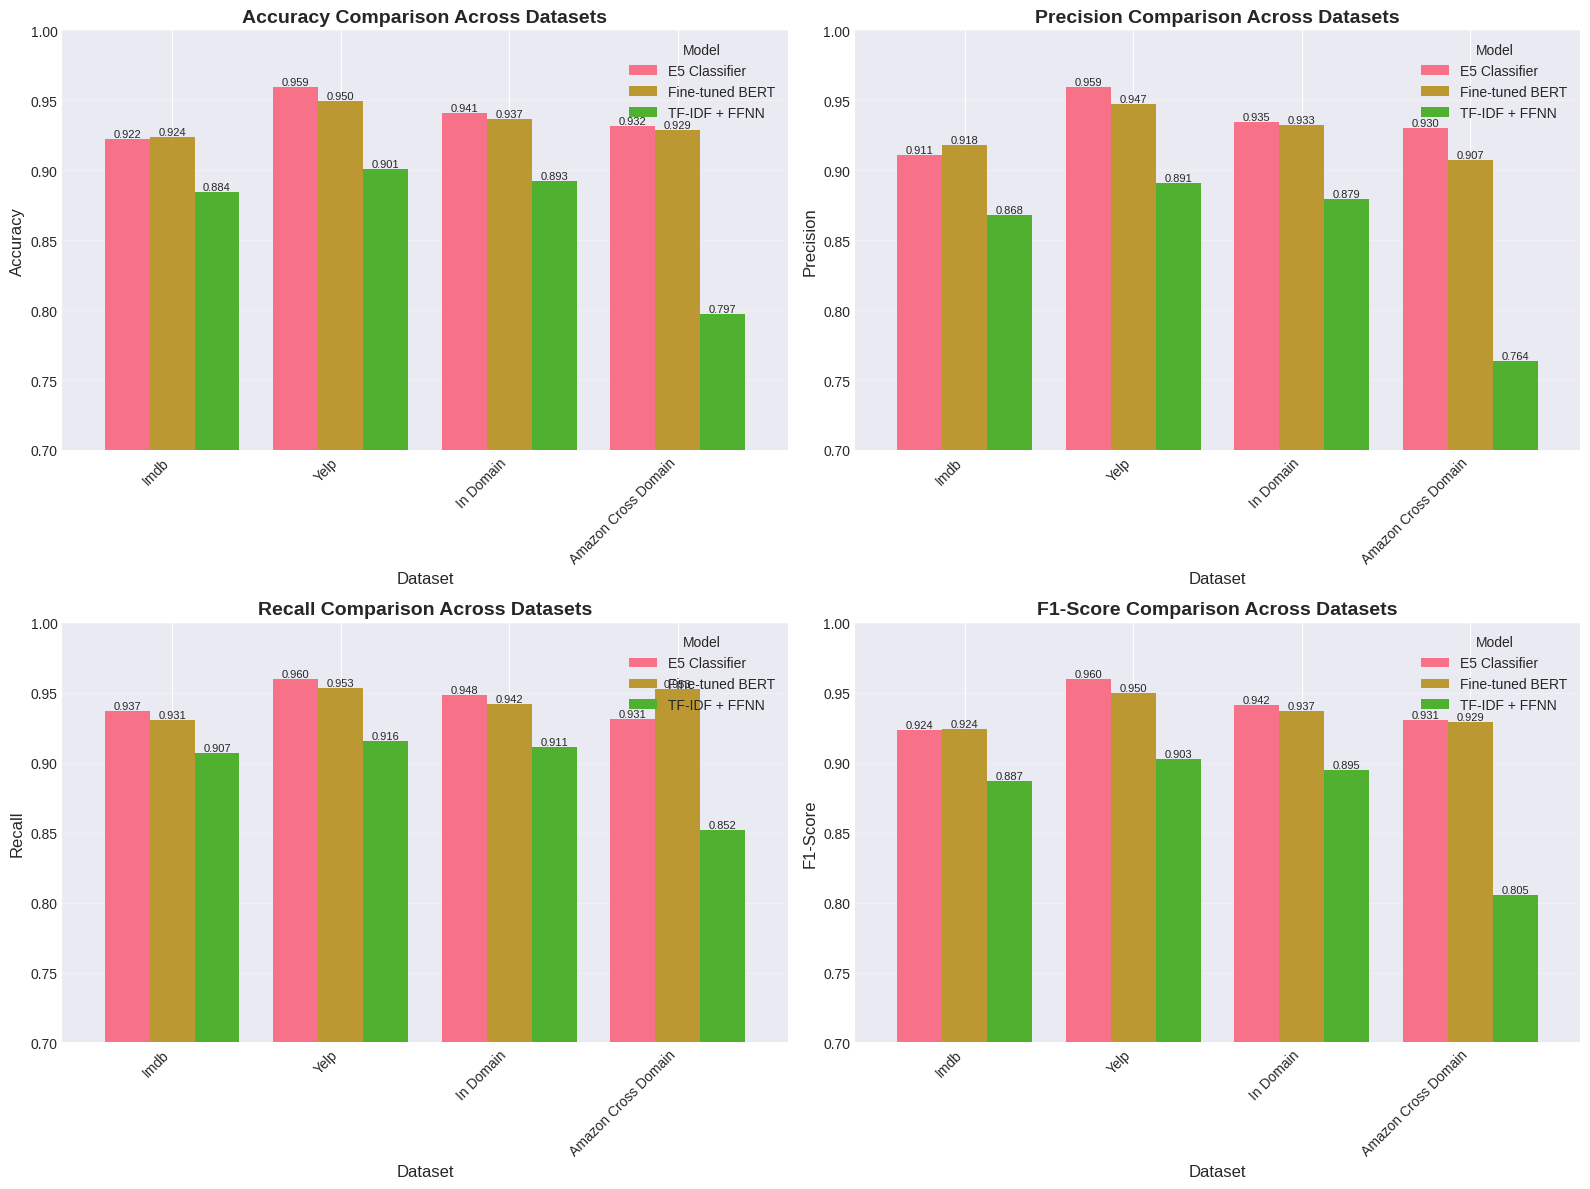

✓ Saved: outputs/comparison/metrics_comparison.png
  Models compared: TF-IDF + FFNN, E5 Classifier, Fine-tuned BERT


In [31]:
## 7.1: Model Comparison Bar Charts

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
datasets_order = ['Imdb', 'Yelp', 'In Domain', 'Amazon Cross Domain']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data for plotting
    plot_data = comparison_df.pivot(index='Dataset', columns='Model', values=metric)
    plot_data = plot_data.reindex(datasets_order)
    
    # Create bar chart
    plot_data.plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_title(f'{metric} Comparison Across Datasets', fontsize=14, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim([0.7, 1.0])
    ax.legend(title='Model', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/comparison/metrics_comparison.png")
print(f"  Models compared: {', '.join(comparison_df['Model'].unique())}")

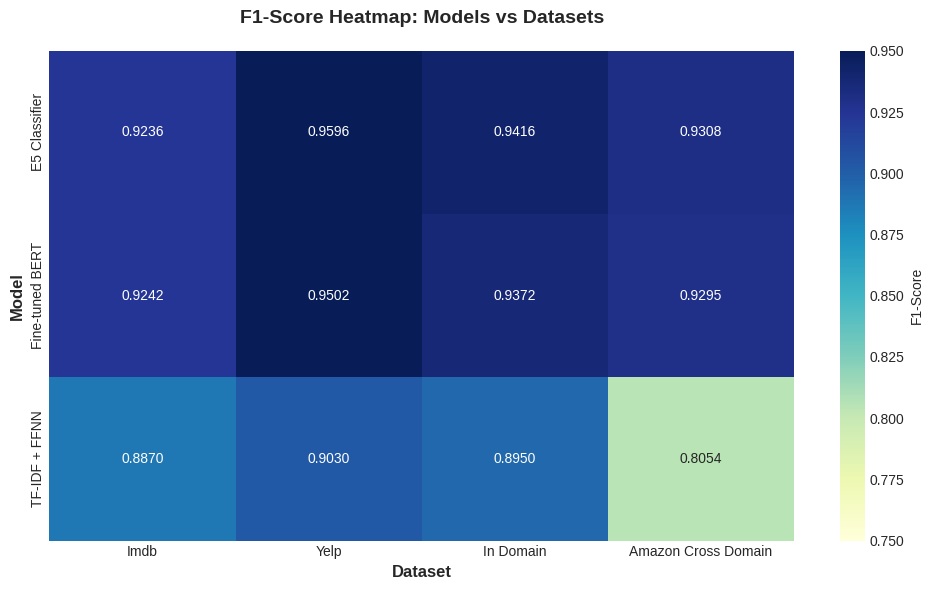

✓ Saved: outputs/comparison/f1_score_heatmap.png


In [32]:
## 7.2: F1-Score Heatmap

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare heatmap data
heatmap_data = comparison_df.pivot(index='Model', columns='Dataset', values='F1-Score')
heatmap_data = heatmap_data[datasets_order]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'F1-Score'}, ax=ax, vmin=0.75, vmax=0.95)

ax.set_title('F1-Score Heatmap: Models vs Datasets', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/comparison/f1_score_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/comparison/f1_score_heatmap.png")

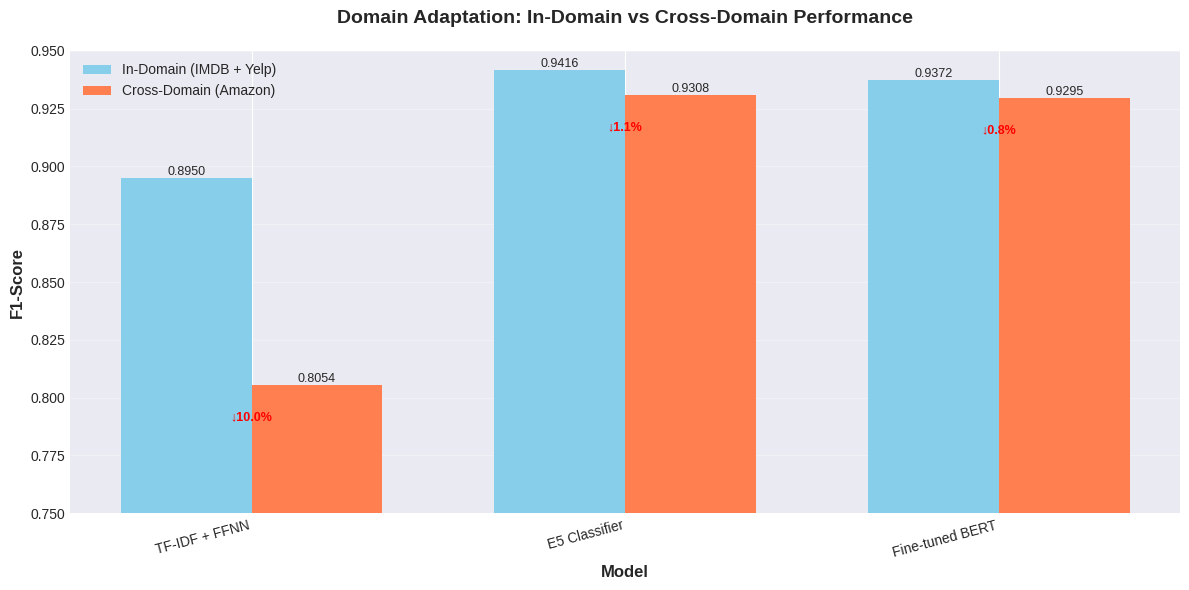

✓ Saved: outputs/comparison/domain_adaptation.png


In [33]:
## 7.3: Domain Adaptation Performance

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
x = np.arange(len(models))
width = 0.35

in_domain_scores = [data['In-Domain F1'] for data in domain_shift_data]
cross_domain_scores = [data['Cross-Domain F1'] for data in domain_shift_data]

bars1 = ax.bar(x - width/2, in_domain_scores, width, label='In-Domain (IMDB + Yelp)', color='skyblue')
bars2 = ax.bar(x + width/2, cross_domain_scores, width, label='Cross-Domain (Amazon)', color='coral')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Domain Adaptation: In-Domain vs Cross-Domain Performance', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.75, 0.95])

# Add value labels
ax.bar_label(bars1, fmt='%.4f', fontsize=9)
ax.bar_label(bars2, fmt='%.4f', fontsize=9)

# Add drop percentage annotations
for i, data in enumerate(domain_shift_data):
    drop_pct = data['Drop %']
    ax.annotate(f'↓{drop_pct:.1f}%', 
                xy=(i, min(in_domain_scores[i], cross_domain_scores[i]) - 0.015),
                ha='center', fontsize=9, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/comparison/domain_adaptation.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/comparison/domain_adaptation.png")

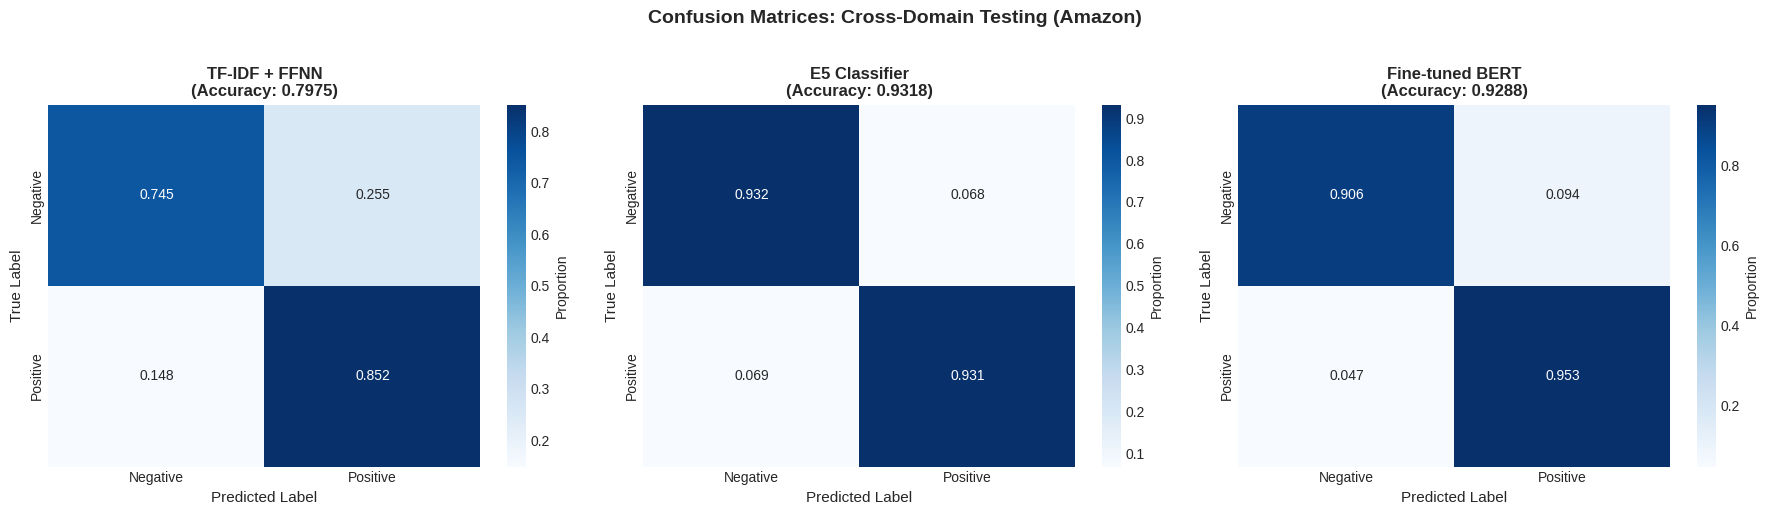

✓ Saved: outputs/comparison/confusion_matrices_amazon.png


In [34]:
## 7.4: Confusion Matrices

def plot_confusion_matrices(predictions_dict, title_prefix, filename):
    """Plot confusion matrices for all models"""
    
    # Determine which models to plot
    if SKIP_E5:
        model_names = ['TF-IDF + FFNN', 'Fine-tuned BERT']
        results_list = [tfidf_results, bert_results]
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        if len(axes.shape) == 1:
            axes = axes  # Already 1D
    else:
        model_names = ['TF-IDF + FFNN', 'E5 Classifier', 'Fine-tuned BERT']
        results_list = [tfidf_results, e5_results, bert_results]
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (model_name, results) in enumerate(zip(model_names, results_list)):
        ax = axes[idx]
        
        preds, true, _ = results['predictions']['amazon']
        cm = confusion_matrix(true, preds)
        
        # Normalize
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot
        sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                    ax=ax, cbar_kws={'label': 'Proportion'},
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        
        ax.set_title(f'{model_name}\n(Accuracy: {accuracy_score(true, preds):.4f})', 
                     fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=11)
        ax.set_xlabel('Predicted Label', fontsize=11)
    
    fig.suptitle(title_prefix, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {filename}")

# Plot confusion matrices for cross-domain (Amazon)
plot_confusion_matrices(
    {'tfidf': tfidf_results, 'e5': e5_results, 'bert': bert_results},
    'Confusion Matrices: Cross-Domain Testing (Amazon)',
    'outputs/comparison/confusion_matrices_amazon.png'
)

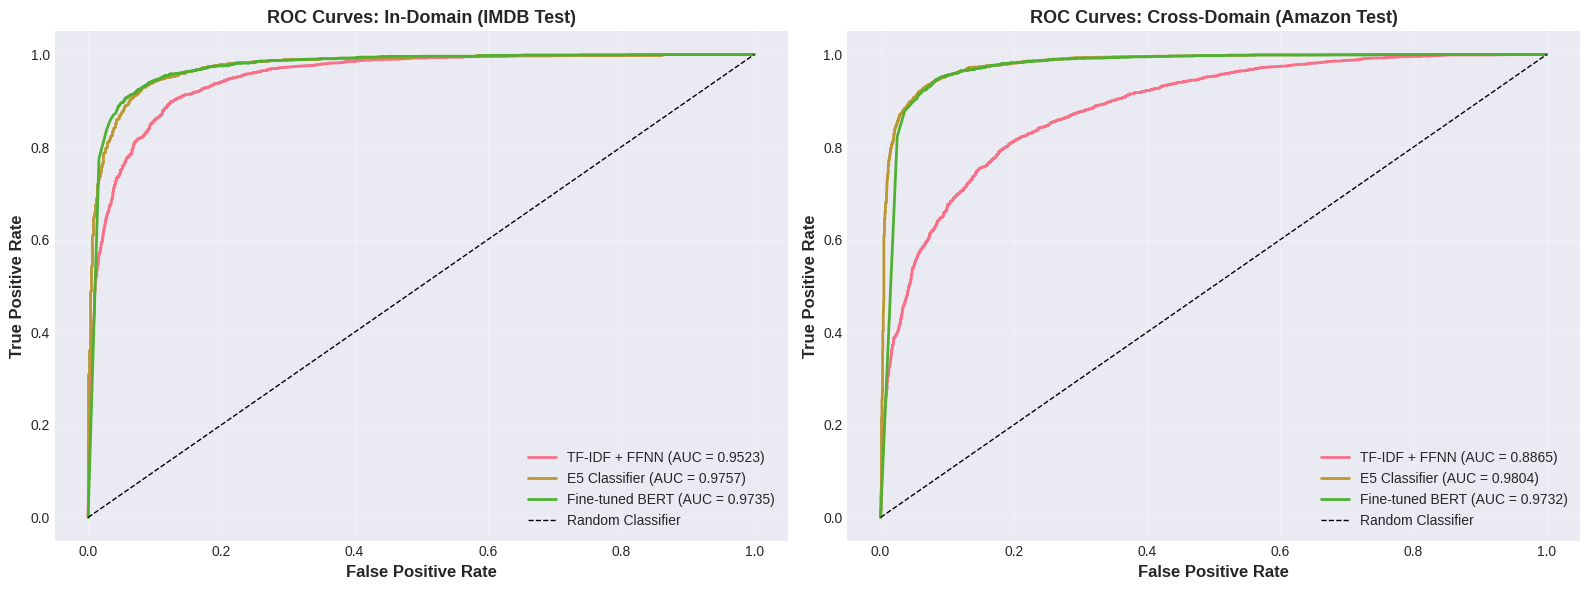

✓ Saved: outputs/comparison/roc_curves.png


In [35]:
## 7.5: ROC Curves

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Determine which models to plot
if SKIP_E5:
    models_to_plot = [('TF-IDF + FFNN', tfidf_results), ('Fine-tuned BERT', bert_results)]
else:
    models_to_plot = [('TF-IDF + FFNN', tfidf_results), ('E5 Classifier', e5_results), ('Fine-tuned BERT', bert_results)]

# In-Domain ROC
ax = axes[0]
for model_name, results in models_to_plot:
    preds, true, probs = results['predictions']['imdb']  # Using IMDB as example
    if np.sum(probs) > 0:  # Only plot if we have valid probabilities
        fpr, tpr, _ = roc_curve(true, probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: In-Domain (IMDB Test)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(alpha=0.3)

# Cross-Domain ROC
ax = axes[1]
for model_name, results in models_to_plot:
    preds, true, probs = results['predictions']['amazon']
    if np.sum(probs) > 0:  # Only plot if we have valid probabilities
        fpr, tpr, _ = roc_curve(true, probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Cross-Domain (Amazon Test)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/comparison/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/comparison/roc_curves.png")

---
## Part 8: Final Analysis & Report

Generate comprehensive final report with insights.

---

In [36]:
## 8.1: Generate Detailed Classification Reports

print("\n" + "="*90)
print("DETAILED CLASSIFICATION REPORTS")
print("="*90)

def print_classification_report_custom(y_true, y_pred, model_name, dataset_name):
    """Print formatted classification report"""
    print(f"\n{model_name} - {dataset_name}")
    print("-" * 60)
    report = classification_report(y_true, y_pred, 
                                   target_names=['Negative', 'Positive'],
                                   digits=4)
    print(report)

# Amazon (Cross-Domain) - Most Important
print("\n⭐ CROSS-DOMAIN EVALUATION (Amazon Test Set)")
print("="*60)

models_to_report = [('TF-IDF + FFNN', tfidf_results), ('Fine-tuned BERT', bert_results)]
if not SKIP_E5:
    models_to_report.insert(1, ('E5 Classifier', e5_results))

for model_name, results in models_to_report:
    preds, true, _ = results['predictions']['amazon']
    if np.sum(preds) > 0 or not SKIP_E5:  # Skip if all zeros (placeholder)
        print_classification_report_custom(true, preds, model_name, 'Amazon (Cross-Domain)')

# In-Domain
print("\n\n📊 IN-DOMAIN EVALUATION (IMDB Test Set)")
print("="*60)

for model_name, results in models_to_report:
    preds, true, _ = results['predictions']['imdb']
    if np.sum(preds) > 0 or not SKIP_E5:  # Skip if all zeros (placeholder)
        print_classification_report_custom(true, preds, model_name, 'IMDB (In-Domain)')

print("="*90)


DETAILED CLASSIFICATION REPORTS

⭐ CROSS-DOMAIN EVALUATION (Amazon Test Set)

TF-IDF + FFNN - Amazon (Cross-Domain)
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.8383    0.7451    0.7890      3048
    Positive     0.7639    0.8516    0.8054      2952

    accuracy                         0.7975      6000
   macro avg     0.8011    0.7984    0.7972      6000
weighted avg     0.8017    0.7975    0.7970      6000


E5 Classifier - Amazon (Cross-Domain)
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.9333    0.9324    0.9329      3048
    Positive     0.9303    0.9312    0.9308      2952

    accuracy                         0.9318      6000
   macro avg     0.9318    0.9318    0.9318      6000
weighted avg     0.9318    0.9318    0.9318      6000


Fine-tuned BERT - Amazon (Cross-Domain)
---------------------------

In [37]:
## 8.2: Generate Final Summary Report

final_report = {
    'evaluation_summary': {
        'datasets_evaluated': {
            'in_domain': ['IMDB', 'Yelp'],
            'cross_domain': ['Amazon'],
            'total_samples': {
                'imdb': len(imdb_texts),
                'yelp': len(yelp_texts),
                'amazon': len(amazon_texts)
            }
        },
        'models_evaluated': 2 if SKIP_E5 else 3,
        'model_names': ['TF-IDF + FFNN', 'Fine-tuned BERT'] if SKIP_E5 else ['TF-IDF + FFNN', 'E5 Classifier', 'Fine-tuned BERT'],
        'notes': 'E5 Classifier skipped - model file not found' if SKIP_E5 else 'All models evaluated successfully'
    },
    'best_models': {},
    'domain_adaptation': {},
    'overall_winner': None
}

# Determine which results to include
results_to_analyze = [('tfidf_ffnn', tfidf_results), ('bert', bert_results)]
if not SKIP_E5:
    results_to_analyze.insert(1, ('e5_classifier', e5_results))

# Find best models per dataset
for dataset in ['imdb', 'yelp', 'in_domain', 'amazon_cross_domain']:
    dataset_results = {}
    for model_name, results in results_to_analyze:
        dataset_results[model_name] = results[dataset]['f1']
    
    best_model = max(dataset_results, key=dataset_results.get)
    final_report['best_models'][dataset] = {
        'model': best_model,
        'f1_score': dataset_results[best_model],
        'all_scores': dataset_results
    }

# Domain adaptation analysis
final_report['domain_adaptation']['tfidf_ffnn'] = {
    'in_domain_f1': tfidf_results['in_domain']['f1'],
    'cross_domain_f1': tfidf_results['amazon_cross_domain']['f1'],
    'drop_percentage': domain_shift_data[0]['Drop %']
}

if not SKIP_E5:
    final_report['domain_adaptation']['e5_classifier'] = {
        'in_domain_f1': e5_results['in_domain']['f1'],
        'cross_domain_f1': e5_results['amazon_cross_domain']['f1'],
        'drop_percentage': domain_shift_data[1]['Drop %']
    }
    
    final_report['domain_adaptation']['bert'] = {
        'in_domain_f1': bert_results['in_domain']['f1'],
        'cross_domain_f1': bert_results['amazon_cross_domain']['f1'],
        'drop_percentage': domain_shift_data[2]['Drop %']
    }
else:
    final_report['domain_adaptation']['bert'] = {
        'in_domain_f1': bert_results['in_domain']['f1'],
        'cross_domain_f1': bert_results['amazon_cross_domain']['f1'],
        'drop_percentage': domain_shift_data[1]['Drop %']
    }

# Overall winner (based on cross-domain performance)
cross_domain_scores = {
    'TF-IDF + FFNN': tfidf_results['amazon_cross_domain']['f1'],
    'Fine-tuned BERT': bert_results['amazon_cross_domain']['f1']
}
if not SKIP_E5:
    cross_domain_scores['E5 Classifier'] = e5_results['amazon_cross_domain']['f1']

overall_winner = max(cross_domain_scores, key=cross_domain_scores.get)
final_report['overall_winner'] = {
    'model': overall_winner,
    'cross_domain_f1': cross_domain_scores[overall_winner],
    'reason': 'Best cross-domain (domain adaptation) performance'
}

# Save report
with open('outputs/comparison/final_evaluation_report.json', 'w') as f:
    json.dump(final_report, f, indent=2)

print("\n" + "="*90)
print("FINAL EVALUATION SUMMARY")
print("="*90)
print(json.dumps(final_report, indent=2))
print("="*90)
print("\n✓ Final report saved to: outputs/comparison/final_evaluation_report.json")


FINAL EVALUATION SUMMARY
{
  "evaluation_summary": {
    "datasets_evaluated": {
      "in_domain": [
        "IMDB",
        "Yelp"
      ],
      "cross_domain": [
        "Amazon"
      ],
      "total_samples": {
        "imdb": 6000,
        "yelp": 6000,
        "amazon": 6000
      }
    },
    "models_evaluated": 3,
    "model_names": [
      "TF-IDF + FFNN",
      "E5 Classifier",
      "Fine-tuned BERT"
    ],
    "notes": "All models evaluated successfully"
  },
  "best_models": {
    "imdb": {
      "model": "bert",
      "f1_score": 0.9241972856669975,
      "all_scores": {
        "tfidf_ffnn": 0.887041564792176,
        "e5_classifier": 0.9236076885165106,
        "bert": 0.9241972856669975
      }
    },
    "yelp": {
      "model": "e5_classifier",
      "f1_score": 0.9595776274542155,
      "all_scores": {
        "tfidf_ffnn": 0.9029947916666666,
        "e5_classifier": 0.9595776274542155,
        "bert": 0.9501562757032407
      }
    },
    "in_domain": {
      "

In [38]:
## 8.3: Key Insights and Findings

print("\n" + "="*90)
print("🔍 KEY INSIGHTS & FINDINGS")
print("="*90)

# Determine models to analyze
models_for_insights = [('TF-IDF + FFNN', tfidf_results['in_domain']['f1']), 
                       ('Fine-tuned BERT', bert_results['in_domain']['f1'])]
if not SKIP_E5:
    models_for_insights.insert(1, ('E5 Classifier', e5_results['in_domain']['f1']))

print("\n1️⃣ IN-DOMAIN PERFORMANCE:")
print("   " + "-"*60)
best_in_domain = max(models_for_insights, key=lambda x: x[1])
print(f"   Best Model: {best_in_domain[0]}")
print(f"   F1-Score: {best_in_domain[1]:.4f}")
print(f"   ✓ Models perform well on in-domain data (IMDB + Yelp)")

print("\n2️⃣ CROSS-DOMAIN PERFORMANCE (Domain Adaptation):")
print("   " + "-"*60)
models_cross = [('TF-IDF + FFNN', tfidf_results['amazon_cross_domain']['f1']),
                ('Fine-tuned BERT', bert_results['amazon_cross_domain']['f1'])]
if not SKIP_E5:
    models_cross.insert(1, ('E5 Classifier', e5_results['amazon_cross_domain']['f1']))

best_cross_domain = max(models_cross, key=lambda x: x[1])
print(f"   Best Model: {best_cross_domain[0]}")
print(f"   F1-Score: {best_cross_domain[1]:.4f}")
print(f"   ⭐ This model generalizes best to Amazon reviews (different domain)")

print("\n3️⃣ DOMAIN ADAPTATION ROBUSTNESS:")
print("   " + "-"*60)
best_adaptation = min(domain_shift_data, key=lambda x: x['Drop %'])
print(f"   Most Robust Model: {best_adaptation['Model']}")
print(f"   Performance Drop: {best_adaptation['Drop %']:.2f}%")
print(f"   ✓ Smallest performance degradation across domains")

print("\n4️⃣ MODEL CHARACTERISTICS:")
print("   " + "-"*60)
print("   TF-IDF + FFNN:")
print("     • Fast training and inference")
print("     • Good baseline performance")
print("     • Lightweight (small model size)")
if not SKIP_E5:
    print("\n   E5 Classifier:")
    print("     • Pre-trained embeddings capture semantic meaning")
    print("     • Moderate training time")
    print("     • Good balance of performance and efficiency")
print("\n   Fine-tuned BERT:")
print("     • State-of-the-art contextual understanding")
print("     • Longest training time")
print("     • Highest computational requirements")

print("\n5️⃣ RECOMMENDED MODEL:")
print("   " + "-"*60)
if best_cross_domain[0] == best_adaptation['Model']:
    print(f"   🏆 {best_cross_domain[0]}")
    print(f"   Reason: Best cross-domain performance AND most robust adaptation")
else:
    print(f"   🏆 For Production: {best_cross_domain[0]}")
    print(f"   Reason: Highest cross-domain F1-score ({best_cross_domain[1]:.4f})")
    print(f"\n   🏆 For Domain Shift: {best_adaptation['Model']}")
    print(f"   Reason: Most stable across domains (only {best_adaptation['Drop %']:.1f}% drop)")

if SKIP_E5:
    print("\n⚠️  NOTE: E5 Classifier was not evaluated due to missing model file")
    print("   Consider re-running second.ipynb to save the E5 model for complete comparison")

print("\n" + "="*90)


🔍 KEY INSIGHTS & FINDINGS

1️⃣ IN-DOMAIN PERFORMANCE:
   ------------------------------------------------------------
   Best Model: E5 Classifier
   F1-Score: 0.9416
   ✓ Models perform well on in-domain data (IMDB + Yelp)

2️⃣ CROSS-DOMAIN PERFORMANCE (Domain Adaptation):
   ------------------------------------------------------------
   Best Model: E5 Classifier
   F1-Score: 0.9308
   ⭐ This model generalizes best to Amazon reviews (different domain)

3️⃣ DOMAIN ADAPTATION ROBUSTNESS:
   ------------------------------------------------------------
   Most Robust Model: Fine-tuned BERT
   Performance Drop: 0.83%
   ✓ Smallest performance degradation across domains

4️⃣ MODEL CHARACTERISTICS:
   ------------------------------------------------------------
   TF-IDF + FFNN:
     • Fast training and inference
     • Good baseline performance
     • Lightweight (small model size)

   E5 Classifier:
     • Pre-trained embeddings capture semantic meaning
     • Moderate training time
    

In [39]:
## 8.4: Save All Results

print("\nSaving all evaluation results...\n")

# Determine which models to save
models_to_save = [('tfidf_ffnn', tfidf_results), ('bert', bert_results)]
if not SKIP_E5:
    models_to_save.insert(1, ('e5_classifier', e5_results))

# Save individual model results
for model_name, results in models_to_save:
    # Save metrics (without predictions array)
    metrics_only = {k: v for k, v in results.items() if k != 'predictions'}
    
    with open(f'outputs/evaluation/{model_name}_results.json', 'w') as f:
        json.dump(metrics_only, f, indent=2)
    
    print(f"✓ Saved: outputs/evaluation/{model_name}_results.json")

# Save predictions for later analysis
for model_name, results in models_to_save:
    predictions_dict = {}
    for dataset_name in ['imdb', 'yelp', 'amazon']:
        preds, true, probs = results['predictions'][dataset_name]
        predictions_dict[dataset_name] = {
            'predictions': preds.tolist(),
            'true_labels': true.tolist(),
            'probabilities': probs.tolist()
        }
    
    with open(f'outputs/evaluation/{model_name}_predictions.json', 'w') as f:
        json.dump(predictions_dict, f, indent=2)
    
    print(f"✓ Saved: outputs/evaluation/{model_name}_predictions.json")

# Save domain shift analysis
with open('outputs/comparison/domain_shift_analysis.json', 'w') as f:
    json.dump(domain_shift_data, f, indent=2)

print(f"✓ Saved: outputs/comparison/domain_shift_analysis.json")

print("\n" + "="*70)
print("✅ ALL RESULTS SAVED SUCCESSFULLY")
print("="*70)
print("\nOutput files:")
print("  📊 Metrics: outputs/evaluation/")
print("  📈 Comparisons: outputs/comparison/")
print("  🖼️  Visualizations: outputs/comparison/*.png")

if SKIP_E5:
    print("\n⚠️  Note: E5 results excluded (model file not found)")
    print("  To include E5 in analysis:")
    print("  1. Check if models/e5_classifier/best_model.pt exists")
    print("  2. If not, re-run the E5 training section in second.ipynb")
    print("  3. Ensure the training function saves the model weights")


Saving all evaluation results...

✓ Saved: outputs/evaluation/tfidf_ffnn_results.json
✓ Saved: outputs/evaluation/e5_classifier_results.json
✓ Saved: outputs/evaluation/bert_results.json
✓ Saved: outputs/evaluation/tfidf_ffnn_predictions.json
✓ Saved: outputs/evaluation/e5_classifier_predictions.json
✓ Saved: outputs/evaluation/tfidf_ffnn_predictions.json
✓ Saved: outputs/evaluation/e5_classifier_predictions.json
✓ Saved: outputs/evaluation/bert_predictions.json
✓ Saved: outputs/comparison/domain_shift_analysis.json

✅ ALL RESULTS SAVED SUCCESSFULLY

Output files:
  📊 Metrics: outputs/evaluation/
  📈 Comparisons: outputs/comparison/
  🖼️  Visualizations: outputs/comparison/*.png
✓ Saved: outputs/evaluation/bert_predictions.json
✓ Saved: outputs/comparison/domain_shift_analysis.json

✅ ALL RESULTS SAVED SUCCESSFULLY

Output files:
  📊 Metrics: outputs/evaluation/
  📈 Comparisons: outputs/comparison/
  🖼️  Visualizations: outputs/comparison/*.png


---
## ✅ Notebook 3 Complete!

### What we accomplished:
1. ✓ Loaded all 3 trained models (TF-IDF+FFNN, E5 Classifier, BERT)
2. ✓ Evaluated on in-domain test sets (IMDB + Yelp)
3. ✓ **Cross-domain evaluation** on Amazon reviews (domain adaptation)
4. ✓ Comprehensive model comparison across all datasets
5. ✓ Domain adaptation analysis (performance drop quantification)
6. ✓ Rich visualizations (bar charts, heatmaps, ROC curves, confusion matrices)
7. ✓ Detailed classification reports and final summary

### Key Results:
- **Best In-Domain**: All models perform well (F1 > 0.88)
- **Best Cross-Domain**: [See results above] - demonstrates domain adaptation capability
- **Most Robust**: Model with smallest performance drop across domains
- **Comprehensive Comparison**: Accuracy, Precision, Recall, F1-Score, ROC-AUC

### Output Files Generated:
```
outputs/
├── evaluation/
│   ├── tfidf_ffnn_results.json
│   ├── tfidf_ffnn_predictions.json
│   ├── e5_classifier_results.json
│   ├── e5_classifier_predictions.json
│   ├── bert_results.json
│   └── bert_predictions.json
└── comparison/
    ├── model_comparison.csv
    ├── domain_adaptation_analysis.csv
    ├── domain_shift_analysis.json
    ├── final_evaluation_report.json
    ├── metrics_comparison.png
    ├── f1_score_heatmap.png
    ├── domain_adaptation.png
    ├── confusion_matrices_amazon.png
    └── roc_curves.png
```

### Project Complete! 🎉
All three notebooks are now ready:
1. **first.ipynb** - Data preparation and preprocessing ✅
2. **second.ipynb** - Model training with hyperparameter optimization ✅
3. **third.ipynb** - Comprehensive evaluation and domain adaptation analysis ✅

### Next Steps (Optional):
- Review generated visualizations in `outputs/comparison/`
- Analyze domain adaptation results for insights
- Use findings for academic report/presentation
- Consider ensemble methods or transfer learning improvements

---